In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import gseapy as gp

from tqdm import tqdm

In [2]:
df = pd.read_csv('attention.csv.gz', index_col=0, low_memory=False)
tmp = np.load('../../Drug_Response_Prediction_using_GNN/exp/idxs.npy', allow_pickle=True)[1]
df.index = tmp
df.columns = tmp
drug = df[:269]
drug_gene = drug.iloc[:, 329:]

In [4]:
for i in drug_gene.columns:
    print(i)

A2M
AAK1
ABCB1
ABL1
ABL2
ABRACL
ACAT1
ACKR3
ACLY
ACO2
ACOT7
ACP1
ACP5
ACTA2
ACTB
ACTG1
ACTG2
ACTL6A
ACTN1
ACTN4
ACVR1
ACVR1B
ACYP1
ADA
ADAM15
ADGRG1
ADI1
ADIPOR1
ADIRF
ADK
ADORA3
ADRM1
ADSL
AES
AGR2
AGRN
AGTRAP
AHCY
AHNAK
AHR
AHSA1
AIF1
AIMP2
AIP
AK6
AKAP12
AKR1A1
AKR1B1
AKR1B10
AKR1C1
AKR1C2
AKR1C3
AKT1
ALB
ALCAM
ALDH1A1
ALDH1A2
ALDH1A3
ALDH2
ALDH3A1
ALDOA
ALDOC
ALG3
ALK
ALOX5
ALYREF
AMIGO2
AMOTL2
ANAPC11
ANAPC13
ANAPC15
ANAPC5
ANKK1
ANKRD1
ANKRD10
ANKRD34B
ANLN
ANP32A
ANP32B
ANPEP
ANXA1
ANXA11
ANXA2
ANXA2P2
ANXA3
ANXA4
ANXA5
ANXA7
AP1M2
AP1S1
AP2M1
AP2S1
AP3S1
APEX1
APIP
APLP2
APMAP
APOA1BP
APOC1
APOC2
APOD
APOE
APP
APRT
AR
AREG
ARF1
ARF4
ARF5
ARFGAP1
ARGLU1
ARHGDIA
ARHGDIB
ARL2
ARL2BP
ARL4C
ARL6IP1
ARL6IP4
ARPC1A
ARPC1B
ARPC2
ARPC3
ARPC5
ARPC5L
ASAH1
ASF1B
ASNA1
ASNS
ASPH
ASS1
ATF4
ATG3
ATIC
ATN1
ATOX1
ATP1A1
ATP1A1-AS1
ATP1B1
ATP1B3
ATP2A3
ATP5A1
ATP5B
ATP5C1
ATP5D
ATP5E
ATP5EP2
ATP5F1
ATP5G1
ATP5G2
ATP5G3
ATP5H
ATP5I
ATP5J
ATP5J2
ATP5L
ATP5O
ATP6AP1
ATP6V0B
ATP6V0C
ATP6V0D1
ATP6V0

In [4]:
human = gp.get_library_name(organism='Human')
human

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisG

In [5]:
def pad_dict(dictionary, pad_value):
    max_length = max(len(v) for v in dictionary.values())
    for key in dictionary:
        dictionary[key] += [pad_value] * (max_length - len(dictionary[key]))
    return dictionary

In [6]:
res = {}
for i in drug_gene.index:
    tmp = drug_gene.loc[i]
    tmp = tmp[tmp != 0]
    if len(tmp) > 0:
        res[i] = list(tmp.sort_values(ascending=False).index)
        
padded_dict = pad_dict(res, None)
res = pd.DataFrame(padded_dict).T

In [7]:
res.loc[740].dropna()[:100]

0        ATIC
1        TYMS
2        DHFR
3      MIR330
4     SNORD16
       ...   
95       HBE1
96       GPX2
97       TFF2
98       APOD
99      PHGR1
Name: 740, Length: 100, dtype: object

In [1]:
results = pd.DataFrame()
for i in res.index:
    while True:
        try:
            enr = gp.enrichr(gene_list=list(res.loc[i].dropna()[:100]), 
                             gene_sets='MSigDB_Hallmark_2020',
                             organism='human', 
                             outdir=None)
            tmp = enr.results
            tmp = tmp[tmp['Adjusted P-value'] < 0.05].sort_values(['Adjusted P-value'])[['Term', 'Adjusted P-value', 'Genes']]
            tmp['drug'] = len(tmp)*[i]
            results = pd.concat([results, tmp])
            break
        except Exception as e:
            print(f"Error: {e}")
            print("Retrying...")

In [ ]:
name = dict(pd.read_csv(
    'nsc_cid_smiles_class_name.csv', 
    index_col=0)[['NSC', 'NAME']].values)

In [ ]:
results['drug'] = [name[int(i)] for i in results['drug']]
results

In [ ]:
df = results.groupby('Term')['drug'].count().reset_index().merge(results.groupby('Term')['Adjusted P-value'].mean().reset_index())
df = df.sort_values('drug', ascending=False)
df = df[df['drug'] > 10]
df

In [ ]:
# df.to_csv('gea.csv')

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('gea.csv', index_col=0)

/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_4274/3979757494.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap_name)
/var/folders/s4/6xgylm7x3yzgfsk6sbvk_7_c0000gn/T/ipykernel_4274/3979757494.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


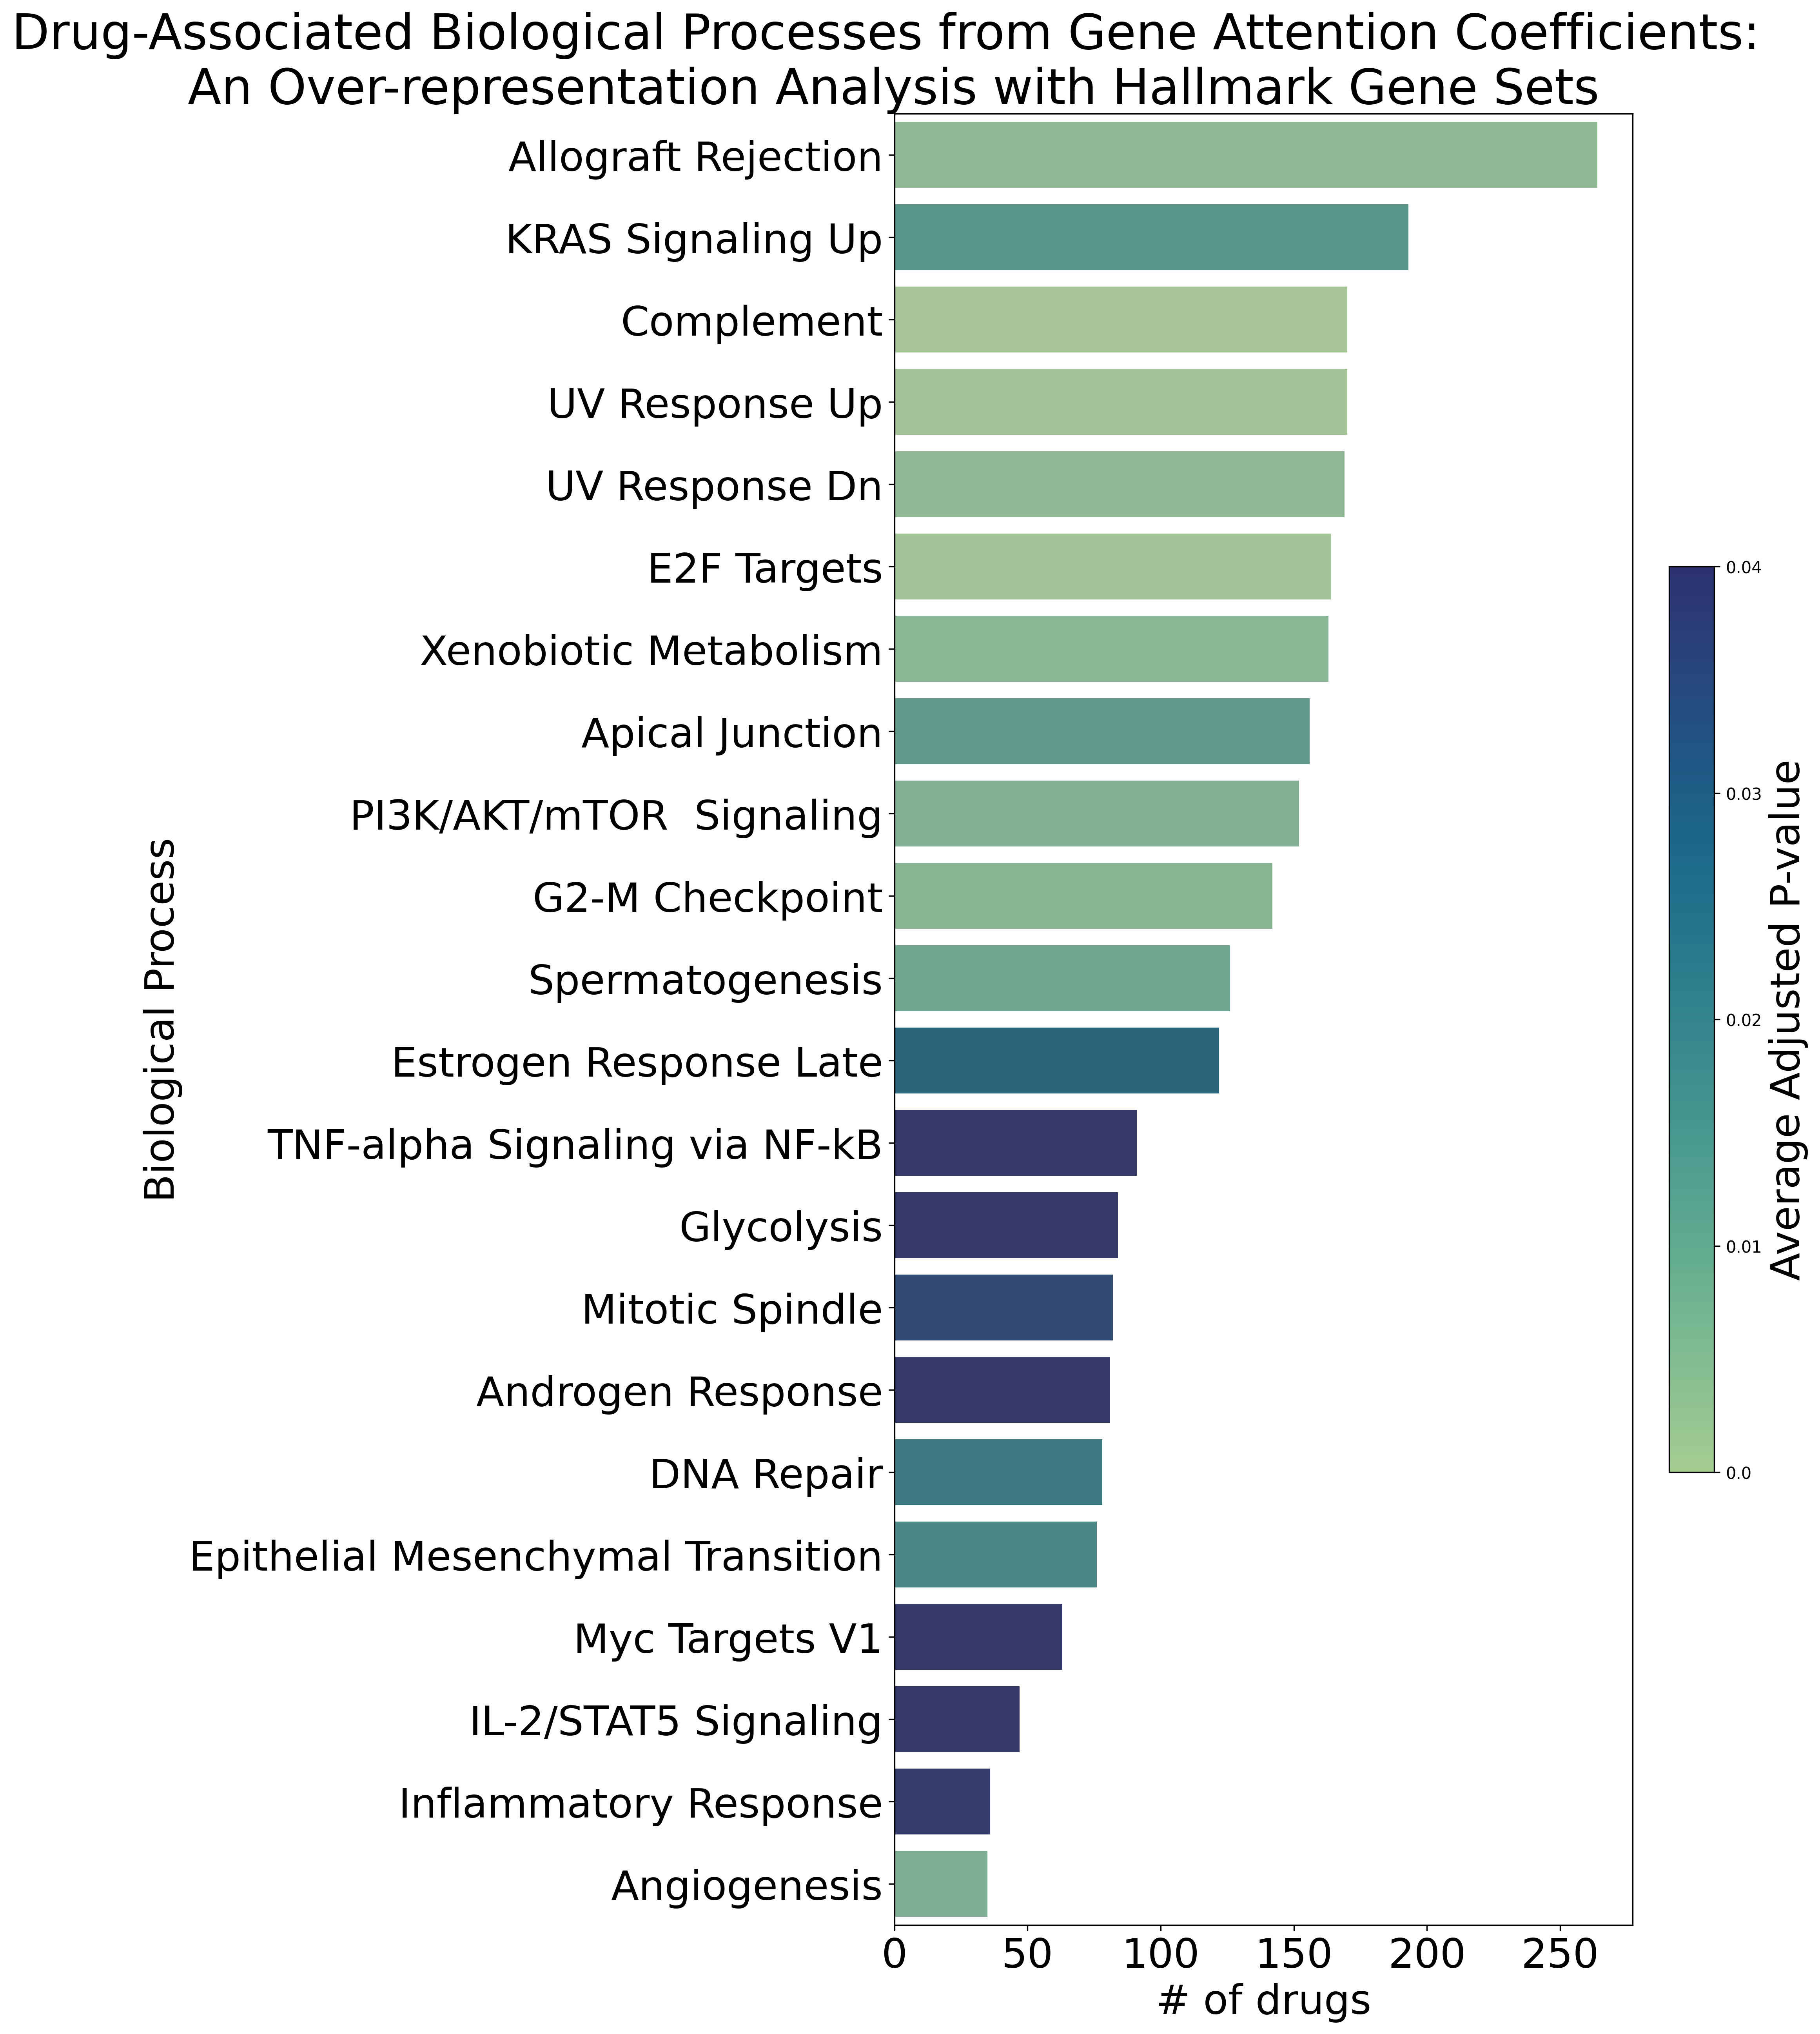

In [3]:
cmap_name = 'crest'
cmap = plt.cm.get_cmap(cmap_name)

plt.rcdefaults()

data = list(df['Adjusted P-value'])

vmin = np.min(data)
vmax = np.max(data)

norm = plt.Normalize(vmin=vmin, vmax=vmax)
colors = [cmap(norm(value)) for value in data]

fig, ax = plt.subplots(figsize=[10, 20], dpi=300)

sns.barplot(
    x='drug', y='Term', 
    data=df.assign(color=colors),  # ここで色の情報をデータフレームに追加
    palette=colors,  # そして、割り当てた色を利用
    dodge=False
)

labelsize=25
ax.tick_params(axis='x', labelsize=labelsize)  # x軸の目盛りフォントサイズ
ax.tick_params(axis='y', labelsize=labelsize) 
ax.set_ylabel('Biological Process', fontsize=labelsize)
ax.set_xlabel('# of drugs', fontsize=labelsize)
ax.set_title(
    'Drug-Associated Biological Processes from Gene Attention Coefficients: \nAn Over-representation Analysis with Hallmark Gene Sets', 
    fontsize=30,
    x=-0.001
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, shrink=0.5, pad=0.04)
cbar.set_label('Average Adjusted P-value', fontsize=labelsize)
cbar.set_ticks(np.linspace(vmin, vmax, num=5))  # numを変更して目盛りの数を調整
cbar.set_ticklabels([round(t, 2) for t in np.linspace(vmin, vmax, num=5)])  # 科学的表記で目盛りラベルを設定

plt.show()